**Kornia**

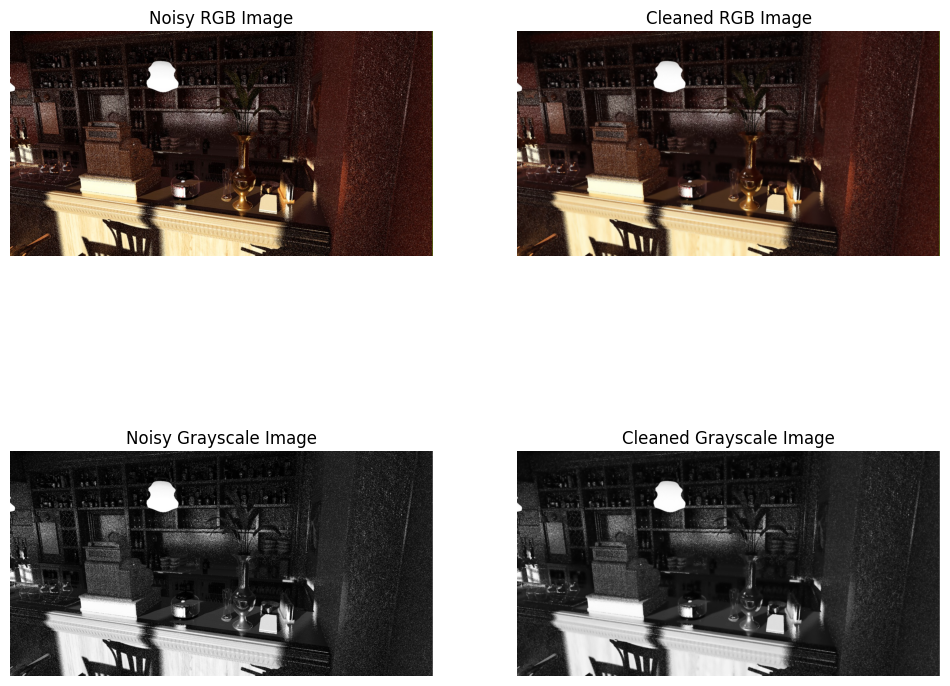

RGB Denoising Execution Time: 1.2251 seconds
File Size Before RGB Denoising: 361.30 KB
File Size After RGB Denoising: 20400.00 KB

Grayscale Denoising Execution Time: 0.2612 seconds
File Size Before Grayscale Denoising: 361.30 KB
File Size After Grayscale Denoising: 6800.00 KB


In [2]:
!pip install kornia

import torch
import kornia
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import time

# Path ke file gambar
image_path = 'noisergb.jpg'

# Baca gambar dengan OpenCV
img: np.ndarray = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255.0  # Mode RGB
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) / 255.0  # Mode Grayscale

# Konversi ke tensor torch
noisy_image_rgb: torch.tensor = kornia.image_to_tensor(img_rgb).squeeze()  # CxHxW
noisy_image_gray: torch.tensor = kornia.image_to_tensor(img_gray).squeeze()  # CxHxW

# Definisikan model denoising dengan total variation
class TVDenoise(torch.nn.Module):
    def __init__(self, noisy_image):
        super(TVDenoise, self).__init__()
        self.l2_term = torch.nn.MSELoss(reduction='mean')
        self.regularization_term = kornia.losses.TotalVariation()
        # Buat variabel yang akan dioptimalkan untuk menghasilkan gambar bebas noise
        self.clean_image = torch.nn.Parameter(data=noisy_image.clone(), requires_grad=True)
        self.noisy_image = noisy_image

    def forward(self):
        l2_loss = self.l2_term(self.clean_image, self.noisy_image)
        tv_loss = self.regularization_term(self.clean_image)
        # Hitung rata-rata loss
        return (l2_loss + 0.001 * tv_loss).mean()

    def get_clean_image(self):
        return self.clean_image

# Inisialisasi model dan optimizer untuk mode RGB
tv_denoiser_rgb = TVDenoise(noisy_image_rgb)
optimizer_rgb = torch.optim.Adam([tv_denoiser_rgb.clean_image], lr=0.01)  # Gunakan Adam optimizer

# Inisialisasi model dan optimizer untuk mode Grayscale
tv_denoiser_gray = TVDenoise(noisy_image_gray)
optimizer_gray = torch.optim.Adam([tv_denoiser_gray.clean_image], lr=0.01)  # Gunakan Adam optimizer

# Waktu eksekusi sebelum optimisasi RGB
start_time_rgb = time.time()

# Jalankan loop optimisasi untuk mode RGB
num_iters = 10  # Tingkatkan jumlah iterasi
for i in range(num_iters):
    optimizer_rgb.zero_grad()
    loss_rgb = tv_denoiser_rgb()
    loss_rgb.backward()
    optimizer_rgb.step()

# Waktu eksekusi setelah optimisasi RGB
end_time_rgb = time.time()

# Waktu eksekusi sebelum optimisasi Grayscale
start_time_gray = time.time()

# Jalankan loop optimisasi untuk mode Grayscale
for i in range(num_iters):
    optimizer_gray.zero_grad()
    loss_gray = tv_denoiser_gray()
    loss_gray.backward()
    optimizer_gray.step()

# Waktu eksekusi setelah optimisasi Grayscale
end_time_gray = time.time()

# Konversi kembali ke numpy
img_clean_rgb: np.ndarray = kornia.tensor_to_image(tv_denoiser_rgb.get_clean_image())
img_clean_gray: np.ndarray = kornia.tensor_to_image(tv_denoiser_gray.get_clean_image())

# Menampilkan gambar hasil denoising
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('Noisy RGB Image')
axs[0].imshow(img_rgb)

axs[1].axis('off')
axs[1].set_title('Cleaned RGB Image')
axs[1].imshow(img_clean_rgb)

axs[2].axis('off')
axs[2].set_title('Noisy Grayscale Image')
axs[2].imshow(img_gray, cmap='gray')

axs[3].axis('off')
axs[3].set_title('Cleaned Grayscale Image')
axs[3].imshow(img_clean_gray, cmap='gray')

plt.show()

# Hitung ukuran file sebelum dan setelah diproses
file_size_before_rgb = os.path.getsize(image_path) / (1024.0)  # konversi ke KB
file_size_after_rgb = np.array(img_clean_rgb).tobytes().__len__() / (1024.0)  # konversi ke KB

file_size_before_gray = os.path.getsize(image_path) / (1024.0)  # konversi ke KB
file_size_after_gray = np.array(img_clean_gray).tobytes().__len__() / (1024.0)  # konversi ke KB

# Tampilkan waktu eksekusi dan ukuran file
print(f"RGB Denoising Execution Time: {end_time_rgb - start_time_rgb:.4f} seconds")
print(f"File Size Before RGB Denoising: {file_size_before_rgb:.2f} KB")
print(f"File Size After RGB Denoising: {file_size_after_rgb:.2f} KB\n")

print(f"Grayscale Denoising Execution Time: {end_time_gray - start_time_gray:.4f} seconds")
print(f"File Size Before Grayscale Denoising: {file_size_before_gray:.2f} KB")
print(f"File Size After Grayscale Denoising: {file_size_after_gray:.2f} KB")


**OpenCV**

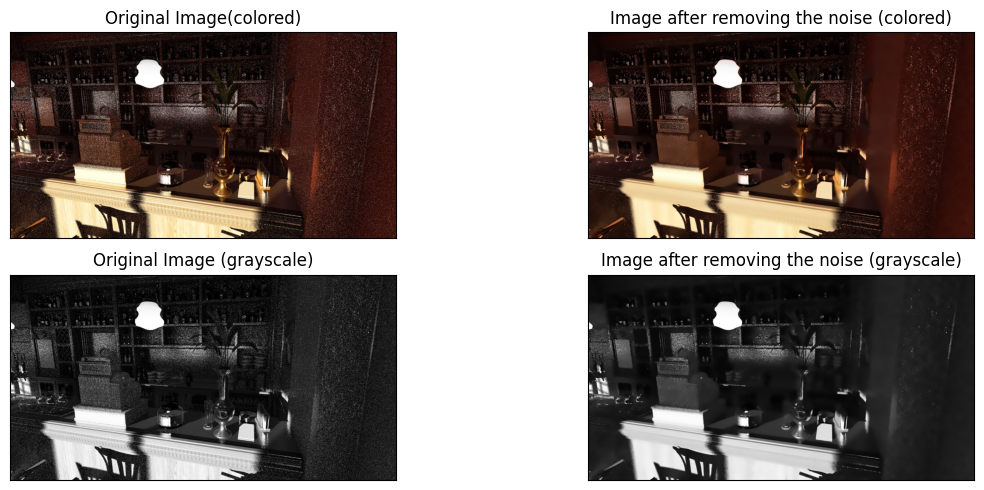

RGB Denoising Execution Time: 4.1801 seconds
Grayscale Denoising Execution Time: 1.0550 seconds

File Size Before RGB Denoising: 361.30 KB
File Size After RGB Denoising: 2550.00 KB


In [3]:

import numpy as np

import cv2

from matplotlib import pyplot as plt

image = cv2.imread('noisergb.jpg',1)
image_bw = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

start_time = time.time()
noiseless_image_bw = cv2.fastNlMeansDenoising(image_bw, None, 20, 7, 21)
end_time = time.time()

start_time_rgb = time.time()
noiseless_image_colored = cv2.fastNlMeansDenoisingColored(image,None,20,20,7,21)
end_time_rgb = time.time()

# Calculate file size before denoising RGB
file_size_before_rgb = os.path.getsize('noisergb.jpg') / (1024.0)  # in KB

# Calculate file size after denoising RGB
file_size_after_rgb = np.array(noiseless_image_colored).tobytes().__len__() / (1024.0)  # in KB

titles = ['Original Image(colored)','Image after removing the noise (colored)', 'Original Image (grayscale)','Image after removing the noise (grayscale)']
images = [image,noiseless_image_colored, image_bw, noiseless_image_bw]
plt.figure(figsize=(13,5))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.imshow(cv2.cvtColor(images[i],cv2.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
plt.show()


# Print computation time
print(f"RGB Denoising Execution Time: {end_time_rgb - start_time_rgb:.4f} seconds")
print(f"Grayscale Denoising Execution Time: {end_time - start_time:.4f} seconds\n")

# Print file size information
print(f"File Size Before RGB Denoising: {file_size_before_rgb:.2f} KB")
print(f"File Size After RGB Denoising: {file_size_after_rgb:.2f} KB")